Importin necessary packages

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.layers import TextVectorization, Embedding, Bidirectional, LSTM, Dense, BatchNormalization, Input

Reading the clean sample files, where rows with non-images are removed and rows are sorted by image id. 

In [53]:
train_sample = pd.read_csv("data/train/train_sample_clean")
test_sample = pd.read_csv("data/test/test_sample_clean")
validate_sample = pd.read_csv("data/validate/validate_sample_clean")

In [54]:
train_sample.head()

,Unnamed: 0,clean_title,id,image_url,5_way_label,files
0,0,perfect execution modern us air force poster,100pp1,https://external-preview.redd.it/cBy5xWF292XdF...,4,data/train/images\5\100pp1.jpg
1,1,bill murray and a potted plant,101453,https://external-preview.redd.it/gPMI9k0_d0gDX...,0,data/train/images\0\101453.jpg
2,2,oh the things he has seen,1016df,https://external-preview.redd.it/adC8wXKw5Qqeu...,2,data/train/images\2\1016df.jpg
3,3,confidence methodically continuing his amputat...,1018ps,https://external-preview.redd.it/fY4bLZ-aBt3QW...,4,data/train/images\5\1018ps.jpg
4,4,retiring boss gives employees for each year th...,102h5n,https://external-preview.redd.it/0qHYWFvuxLzjk...,0,data/train/images\0\102h5n.jpg


As we can see above by the column name, the titles are already clean in version this version of the dataset, so punctuation is to be removed and no lowering of letters is needed. 

Making sure no titles are null. All NaNs are already removed in the previous notebook "to_clean_sample"

In [55]:
train_sample["clean_title"].isnull().sum(), test_sample["clean_title"].isnull().sum(), validate_sample["clean_title"].isnull().sum()

(0, 0, 0)

As seen above no titles are null. 

Extracting the clean title column as text. 

In [56]:
title_train = train_sample["clean_title"]
title_test = test_sample["clean_title"]
title_validate = validate_sample["clean_title"]

Extracting the labels. Have to make sure they are categorical, meaning each integer label will get converted to a array of length six using one-hot-encoding, where the position of the label is 1 and the rest i 0. 

In [57]:
y_train = to_categorical(train_sample["5_way_label"])
y_test = to_categorical(test_sample["5_way_label"])
y_validate = to_categorical(validate_sample["5_way_label"])

In [58]:
y_train

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]])

Finding length of sequence output. Meaning how long each vectorized sentence is. First all the title-lengths are plotted. 

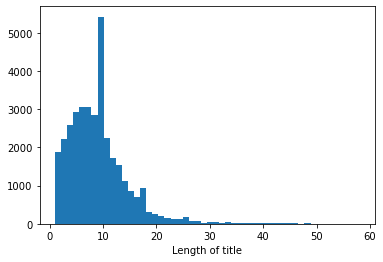

In [59]:
plt.hist(title_train.apply(lambda x: x.split(" ")).apply(len), bins=50)
plt.xlabel("Length of title")
plt.show()

Finding the mean of length plus two standard deviations, which should cover most the data. 

In [60]:
title_train.apply(lambda x: x.split(" ")).apply(len).mean() + title_train.apply(lambda x: x.split(" ")).apply(len).std()

14.762146538081941

As seen above it is just under 15. Will check how much data is lost. 

In [61]:
(title_train.apply(lambda x: x.split(" ")).apply(len) <= 16).sum()/len(title_train)

0.9192681532304173

As seen above, 92% of information is contained when having 16 as max length of output sequence. 

Finding feasible numbers of maximum words in the vectorizers vocabulary. Meaning how many different integers each word can be mapped into. 

Will first find number of unique words in the sample-dataframe using pandas.explode, expanding the dataframe to contain a single word in each row, followed by unique. Then the length of this array/Series is found, and is number of unique words. 

In [12]:
len(train_sample["clean_title"].apply(lambda x: x.split(" ")).explode("clean_sample").unique())

30587

As seen above, the titles contain 30587 unique words. Meaning 2**15=32768 as maximum number of words/integer signatures in the vectorizer will  be enough to get a unique integer value for each word in the vocabulary. No information lost. 

Constructing the vectorizer, which would remove punctuation and perform lowering of sentences, even though it's already done. Output mode is "int", as every unique word will get a unique integer signature. 

In [13]:
max_words = 2**15
max_sequence_length = 16

vectorizer = TextVectorization(max_tokens=max_words, output_sequence_length=max_sequence_length, output_mode="int")

Adapting vectorizer to the training-titles.

In [14]:
vectorizer.adapt(title_train.values)

Tokenizing the clean titles in the dataframe

In [15]:
tokenized_train = vectorizer(title_train.values)
tokenized_test = vectorizer(title_test.values)
tokenized_validate = vectorizer(title_validate.values)

In [16]:
tokenized_train

<tf.Tensor: shape=(34980, 16), dtype=int64, numpy=
array([[  445,  2840,   533, ...,     0,     0,     0],
       [  205,  4391,    10, ...,     0,     0,     0],
       [  564,     2,   275, ...,     0,     0,     0],
       ...,
       [ 2537,  4975,  3326, ...,     0,     0,     0],
       [ 1627,    64,  1852, ...,     0,     0,     0],
       [   26,   424, 19801, ...,     0,     0,     0]], dtype=int64)>

As seen above, every sentence becomes an array with 16 integer values. If title is shorter than 16 words, it's padded with zeros. The words in the vectorizers vocabulary is sorted after occurence. Looking above at row 3, word 2 and comparing it with last row and word 3 it is clear that these two words occur on a different basis. Will take a closer look at those sentences to see how vectorizer sorts words after occurence.

In [17]:
train_sample["clean_title"][2], train_sample["clean_title"][34979]

('oh the things he has seen',
 'after doing pushups the tiger reveals himself to be clemsons president barker')

Looking at the sentences above it makes sense that "the" is the most occuring word and that "pushups" is way down the list. 

In [18]:
vectorizer("a the in has is"), vectorizer("wqqggw hhtheth")

(<tf.Tensor: shape=(16,), dtype=int64, numpy=
 array([ 3,  2,  5, 21, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       dtype=int64)>,
 <tf.Tensor: shape=(16,), dtype=int64, numpy=array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)>)

Comparing the two tokenized vectors above one can see that common words have low numbers, and unknown words will all be tokenized to integer value 1. Saying that if there is a word in validate and test that does not exist in train-data it will get value 1, as it's not known for the vocabulary. 

Constructing tensorflow datasets from titles and labels. 

In [19]:
data_train = tf.data.Dataset.from_tensor_slices((tokenized_train, y_train))
data_test = tf.data.Dataset.from_tensor_slices((tokenized_test, y_test))
data_validate = tf.data.Dataset.from_tensor_slices((tokenized_validate, y_validate))

Defining function for preprocessing the datasets. Which includes caching, shuffling, batching in sizes of 16 (same as for images), and prefetching at autotuned rate, to avoid bottlenecks in the input pipeline of the model to be constructed. 

In [20]:
def pre_pro_data(dataset):
    dataset = dataset.cache()
    dataset = dataset.shuffle(len(dataset))
    dataset = dataset.batch(16)
    return dataset.prefetch(tf.data.AUTOTUNE)

In [21]:
data_train = pre_pro_data(data_train)
data_test = pre_pro_data(data_test)
data_validate = pre_pro_data(data_validate)

Creating the model, which is sequential. Containing embedding layer, followed by batch normalization. Then a bidirectional LSTM layer compresses the input, followed by two dense layers, where last layer is output layer. Model is compiled with loss function, optimizer and metrics for evaluation. 

In [22]:
model = Sequential()

model.add(Input(shape=(16,)))

model.add(Embedding(max_words+1, 32))
model.add(BatchNormalization())

model.add(Bidirectional(LSTM(32, activation="tanh", recurrent_activation="sigmoid")))

model.add(Dense(64, activation="relu"))

model.add(Dense(5, activation="softmax"))

model.compile(loss=tf.losses.categorical_crossentropy, optimizer="Adam", metrics=[tf.keras.metrics.CategoricalAccuracy()])

Model summary

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 16, 32)         │     1,048,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,069,861 (4.08 MB)

 Trainable params: 1,069,797 (4.08 MB)

 Non-trainable params: 64 (256.00 B)

Saving model plot as png-file.

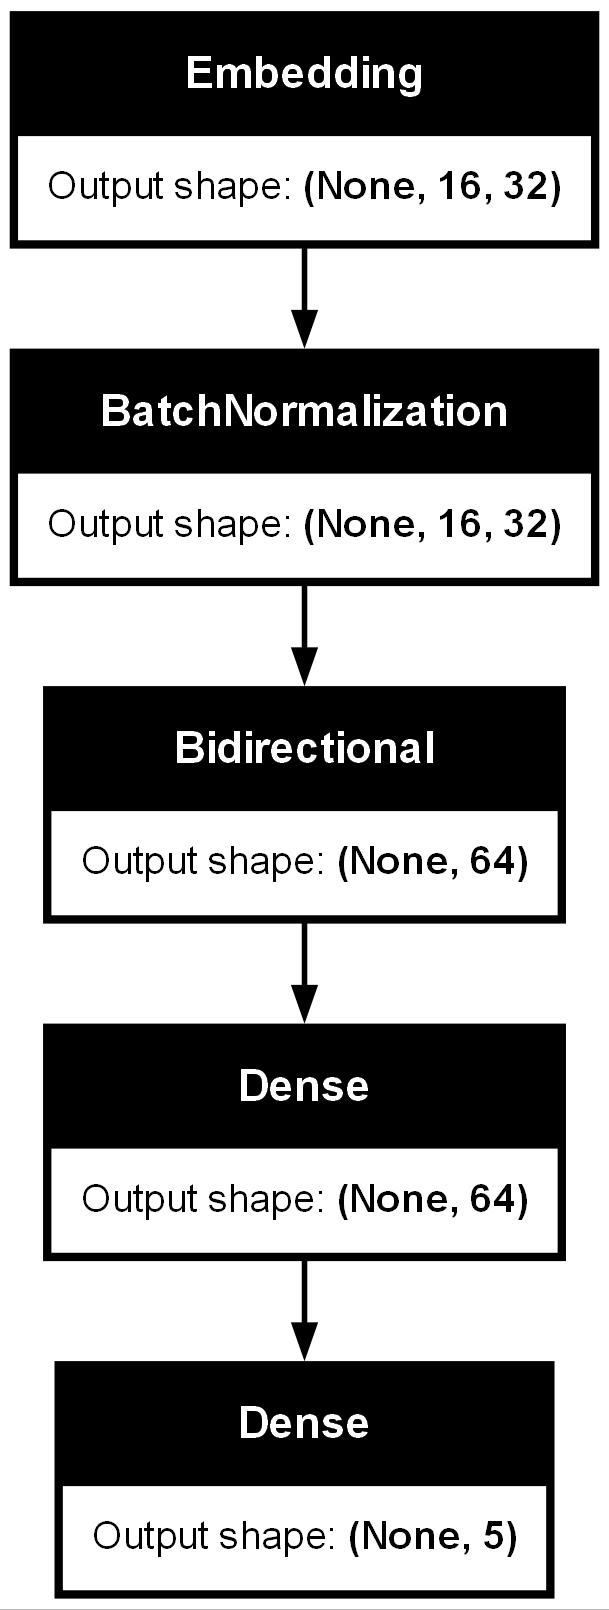

In [24]:
os.environ["PATH"] += os.pathsep + 'C:/Programfiler/Graphviz/bin/'
tf.keras.utils.plot_model(model, to_file="model_text.jpg", show_shapes=True)

In [25]:
history = model.fit(data_train, epochs=1, validation_data=data_validate)

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 43s 18ms/step - categorical_accuracy: 0.6508 - loss: 0.9391 - val_categorical_accuracy: 0.7233 - val_loss: 0.7395


Predicting the labels for the testing data set, and evaluating the results with confusion matrix and F1-score. Iterating through every batch in the dataset, and extending with both predicted labels and actual labels. 

Converting labels back to integer labels in order to calculate confusion matrix. Finds the index of each single label where largest element is located. 

In [31]:
y_actual = []
y_predicted = []
for batch in data_test.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)
    y_actual.extend(y)
    y_predicted.extend(y_pred)

y_actual = np.argmax(np.array(y_actual), axis=-1)
y_predicted = np.argmax(np.array(y_predicted), axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

In [48]:
confusion_mat = tf.math.confusion_matrix(y_actual, y_predicted)
confusion_mat = np.array(confusion_mat)
confusion_mat

array([[2018,   26,  165,    1,   22],
       [ 154,   61,   48,    0,   10],
       [ 328,   23,  556,    0,   16],
       [  57,    9,    8,    1,    7],
       [  63,    8,   20,    0,  109]])

In [50]:
def get_accuracy(confusion_matrix):
    return confusion_matrix.trace()/confusion_matrix.sum()

In [51]:
accuracy = get_accuracy(confusion_mat)
accuracy

0.7398921832884097

Finally calculating the F1-score for each class. 

In [63]:
def get_F1_score(confusion_matrix):
    recall = []
    precision = []

    for i in range(len(confusion_matrix)):
        recall.append(confusion_matrix[i,i]/confusion_matrix[i,:].sum())
        precision.append(confusion_matrix[i,i]/confusion_matrix[:,i].sum())

    recall = np.array(recall)
    precision = np.array(precision)

    return recall, precision, (2*recall*precision)/(recall+precision)

In [64]:
recall, precision, F1_score = get_F1_score(confusion_mat)
recall, precision, F1_score

(array([0.90412186, 0.22344322, 0.60238353, 0.01219512, 0.545     ]),
 array([0.77022901, 0.48031496, 0.69761606, 0.5       , 0.66463415]),
 array([0.83182193, 0.305     , 0.64651163, 0.02380952, 0.5989011 ]))